# The FVA

The main objective of this project is to claculate the FVA (funding valuation adjustment) of a portfolio of options which have the same underlying asset but different maturities and strikes.  
We can recall that the FVA is originated from the funding costs over OIS, and equal to: 

\begin{equation}
FVA_{t}=\Theta_{t}^{0}-\Theta_{t}=E_{t}[\int_{t}^{T} e^{-r(s-t)}\lambda_{s}(u(s,S_{s})-\alpha f\sigma S_{s}|\partial_{S}u(s,S_{s})|)^{+}ds]
\end{equation}

Its parameters are volatility $\sigma$, funding liquidity basis $\lambda$, risk free interest rate $r$, quantile level $f$, and mis-hedge parameter $\alpha$. The underlying asset S is definitely included.

# The Sustainable Black-Scholes PDE

$$
\partial_{t}v+\mathcal{A}_{S}^{bs}+\lambda(u_{bs}-v-\alpha f \sigma S|\Delta_{bs}-\partial_{S}v|)^{+}-rv=0\ on\ [0,T) \times (0,\infty)
$$
where $v(T,S)=0$ for $S$ on $(0,\infty)$ as the terminal condition, $\mathcal{A}_{S}^{bs}=(r-q)S\partial_{S}+\dfrac {1} {2} \sigma^{2}S^{2}\partial^{2}_S$.  

# Global import：

In [10]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# The B-S portofolio value

We have, for $t \leq T^i$:
\begin{equation}
   u_{BS}= \sum_{i=1}^{n}C_t^{i} = \sum_{i=1}^{n}[S_t^{i} \mathcal{N} \left( d_+^i \right) - K_i e^{-r (T^{i} - t)} \mathcal{N} \left( d_-^{i} \right)]
\end{equation}
with: $d_{\pm}^{i} = \frac{1}{\sigma \sqrt{T^i - t}} \left[
\ln \left( \frac{S_t}{K^i} \right) + \left( r \pm \frac{\sigma^2}{2} \right) (T^i - t)
\right]$ where $\mathcal{N}$ is the standard normal distribution CDF.

# Individual option

In [11]:
def bs_call_price(S=100., r=0.02, q=0.01, sigma=0.2, t=0., T=1., K=100.):
    ttm = T - t
    
    if ttm < 0:
        return (np.zeros(len(S)),np.zeros(len(S)))
    elif ttm == 0.:
        return (np.maximum(S - K, 0.),np.sign(np.maximum(S - K, 0.)))

    vol = sigma * np.sqrt(ttm)

    d_minus = np.log(S / K) + (r - q - 0.5 * sigma**2) * ttm
    d_minus /= vol 

    d_plus = d_minus + vol
    
    F = S * np.exp((r - q) * ttm)
    
    res = F * norm.cdf(d_plus)
    res -= K * norm.cdf(d_minus)
    res *= np.exp(-r * ttm)
    delta=norm.cdf(d_plus)
    
    return (res,delta)

# Multiple options

In [12]:
def bs_portfolio(S=100., r=0.02, q=0.01, sigma=0.2, t=0.,
                 T=[0.8 , 1.0], K=[100. , 120.]):
    
        portfolio = [bs_call_price(S, r, q, sigma, t, T_c,K_c)
                     for T_c,K_c in zip(T,K)]
        
        return(np.sum(portfolio,axis = 0))

# Finite difference algorithms

To derive the explicit scheme on $X:=\ln S$, one should firstly notice that there exists a simple relation between the derivative on $X$ and derivative on $S$:
\begin{align*}
S\partial_{S}&=\partial_{X}\\
S^{2}\partial_{S^{2}}^{2}&=\partial^{2}_{X^{2}}-\partial_{X}
\end{align*}
With these two relations, one can easily rewrite the PDF above using X, and thus derive the backward explicit scheme on $X$:
\begin{align*}
\dfrac{v_{X}^{t}-v_{X}^{t-\Delta t}}{\Delta t}+(r-q-\dfrac{1}{2}\sigma^2)\dfrac{v_{X+\Delta X}^{t}-v_{X-\Delta X}^{t}}{2\Delta X}+\dfrac{1}{2}\sigma^2\dfrac{v_{X+\Delta X}^{t}-2v_{X}^{t}+v_{X-\Delta X}^{t}}{(\Delta X)^{2}}+\\
\lambda(\tilde{u}_{bs}(t,X)-v_{X}^{t}-\alpha f \sigma|e^{X}\tilde{\Delta}_{bs}(t,X)-\dfrac{v_{X+\Delta X}^{t}-v_{X}^{t}}{\Delta X}|)^{+}-rv_{X}^{t}=0
\end{align*}
where $\tilde{f}_{bs}(t,X)=f_{bs}(t,S)$, $f=ubs,\Delta$

# Boundary Condition#
Since the numerical implementation requires localizing the problem on a bounded domain, the judicious boundary conditions have to be imposed. Now that it's difficult to determine directly a good approximation for the boundary value, the Dirichlet boundary is not pratical here. Instead, it's reasonable to assume that for a intensive mesh, the boundary value is very close to the nearest point in a given time. 

A rational choice will be the Van Neuman conditions specify the value of the first order derivatives function at the boundary of the PDE.
Here, we use the following a Van Neuman condition which equals zero so as to satisfy the invariance near the boundary:

\begin{align*}
{\displaystyle {\frac {\partial FVA}{\partial \mathbf {x} }}(\mathbf {x} )=0 \quad \forall \mathbf {x} \in \partial D }
\end{align*}


# Grid settings and Model parameters

In [13]:
### setting of model-specific parameters
r = 0.1
q = 0.01
sigma = 0.8
lamda = 0.02
f = 1.96

### define the function to decide the range and the number of grids for log price 
def gridsetting(S,T_range,M):
    
    Phi_99 = 2.58
    
    Mean = np.log(S) + (r - q - 0.5 * sigma**2) * T_range
    Con_Int = sigma * Phi_99 * np.sqrt(T_range)
    
    X_max = Mean + Con_Int
    X_max = np.ceil(X_max)
    
    X_min = Mean - Con_Int
    X_min = np.floor(X_min)
    
    # number of grids on log price range
    N = int(np.sqrt((X_max - X_min)**2 * M / T_range))
    
    return(X_max, X_min, N)

# Solve the PDE by finite difference

In [14]:
### setting of contract-specific parameters
S=100 # initial stock price
T_range = 1.0 # range on time space is [O,T_range)
M = 900 # number of grids on time range

   
X_max, X_min, N = gridsetting(S,T_range,M) 

# define the function to solve the PDE
def EDP(T=[1.0 , 0.8], K=[100. , 120.], alpha = 0.1):
    
    dt = T_range / M
    dx = (X_max - X_min) / N
    
    c_bc = 0
    
    X_linspace = np.linspace(X_min,X_max,N+1)
    
    # initialization of solution area
    # the terminal condition is already satisfied within the initialization
    U = np.zeros((N+1,M+1))

    def Iteration(t,Ut, alpha):
        
        Ut_p = np.zeros(len(Ut))        
        
        S_linspace = np.exp(X_linspace)        
        
        ubs, delta = bs_portfolio(S_linspace, r, q, sigma, t, T, K)
        
        p1 = Ut[1:-1]        
        
        p2 = (r - q - 0.5 * sigma**2 ) * (Ut[2:] - Ut[:-2]) * (2 * dt / dx)
        
        p3 = 0.5 * sigma**2 * (Ut[2:] - 2 * Ut[1:-1] + Ut[:-2]) * (dt / dx**2)
        
        
        p4_c = ubs[1:-1] - Ut[1:-1] - sigma * alpha * f * \
        abs(S_linspace[1:-1] * delta[1:-1] - (Ut[2:] - Ut[:-2]) / (2 * dx))
        p4 = dt * lamda * np.maximum(p4_c, 0)
        
        p5 = -dt * r * Ut[1:-1]    
        
        Ut_p[1:-1] = p1 + p2 + p3 + p4 + p5
        
        ### apply boundary condition
        Ut_p[0] = Ut_p[1] - dx * c_bc
        Ut_p[-1] = Ut_p[-2] + dx * c_bc
        
        return Ut_p

    # recursively solve the PDE by finite difference
    for k in range(M,0,-1):
        U[:,k-1] = Iteration(k*dt, U[:,k], alpha)  
    return U


# apply the PDE solver
# Attetion, the input T and K is in the form of list
U = EDP(T=[1.0], K=[100], alpha = 0.1)

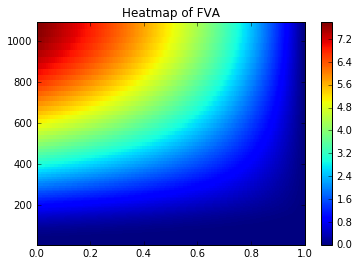

In [15]:
plt.pcolor(np.linspace(0, T_range, M+1),
           np.exp(np.linspace(X_min, X_max, N+1)), U)
plt.title('Heatmap of FVA')
# set the limits of the plot to the limits of the data
plt.axis([0, T_range, np.exp(X_min), np.exp(X_max)])
plt.colorbar()
plt.show()

In [16]:
# Finally, the FVA of a at-the-money option is given 
idx = np.argmin(np.abs(np.exp(np.linspace(X_min, X_max, N+1)) - S))
FVA = U[idx,0]
FVA

0.22018908304824564

At last, it could be interesting to investigate the relation between the hedge propotion $\alpha$ and the FVA.

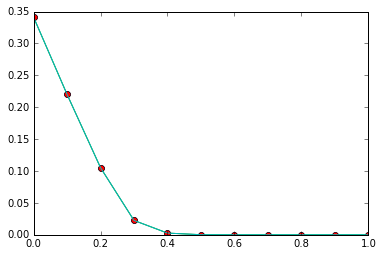

In [9]:
FVA_v = [EDP(T=[1.0], K=[100], alpha = alpha)[idx,0] 
         for alpha in np.linspace(0,1,11)]
plt.plot(np.linspace(0,1,11), FVA_v, "o",np.linspace(0,1,11), FVA_v)
plt.show()

# Remark : Courant–Friedrichs–Lewy (CFL) condition

To check the stability of the schema, we use the CFL of the following form:
$C=\frac{\triangle t}{\triangle S^2}\leq C_{max}$  

The value of  $C_{max}$ changes with the method used to solve the discretised equation, especially depending on whether the method is explicit or implicit. Here we use an explicit schema, then a common choice of $C_{max}$ will be 1. 